In [1]:
import mlflow
import xgbfir

In [2]:
def get_or_create_experiment(name):
    experiment = mlflow.get_experiment_by_name(name)
    if experiment is None:
        mlflow.create_experiment(name)
        return mlflow.get_experiment_by_name(name)
    
    return experiment

def _eid(name):
    return get_or_create_experiment(name).experiment_id

In [3]:
_eid('starter_1')

'3'

In [4]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import cross_validate, KFold
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Visuals
import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Missing data
from sklearn.impute import KNNImputer

In [5]:
df_train = pd.read_hdf('../input/tram.train.h5')
df_test = pd.read_hdf('../input/tram.test.h5')

df = pd.concat([df_train, df_test], axis=0)

print(df.shape)

(308152, 11)


In [6]:
df

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
0,0,0.0,2018-07-23 06:00:47,612,Borsucza,22,Walcownia,2018-07-23 06:00:00,6.352185e+18,6351558574044899587,7.0
1,1,0.0,2018-07-23 06:00:48,572,Smolki,11,Czerwone Maki P+R,2018-07-23 06:00:00,6.352185e+18,6351558574044670211,10.0
2,2,0.0,2018-07-23 06:00:49,322,Filharmonia,8,Bronowice Małe,2018-07-23 06:01:00,6.352185e+18,6351558574044592386,15.0
3,3,0.0,2018-07-23 06:00:51,363,Hala Targowa,1,Salwator,2018-07-23 06:01:00,6.352185e+18,6351558574044379394,24.0
4,4,0.0,2018-07-23 06:00:52,78,Batorego,24,Bronowice Małe,2018-07-23 06:00:00,6.352185e+18,6351558574044948738,19.0
...,...,...,...,...,...,...,...,...,...,...,...
308141,308141,NaN,NaN,89,Bronowice,14,Bronowice Małe,2018-07-31 23:55:00,6.352185e+18,6351558574044741905,33.0
308142,308142,NaN,NaN,2690,Kampus UJ,18,Czerwone Maki P+R,2018-07-31 23:57:00,6.352185e+18,6351558574044791061,24.0
308143,308143,NaN,NaN,133,Wesele,14,Bronowice Małe,2018-07-31 23:56:00,6.352185e+18,6351558574044741905,34.0
308144,308144,NaN,NaN,630,Bieżanowska,24,Kurdwanów P+R,2018-07-31 23:56:00,6.352185e+18,6351558574044950804,23.0


# FEATURE ENGIEERING

In [61]:
#pd.options.display.max_rows = 999

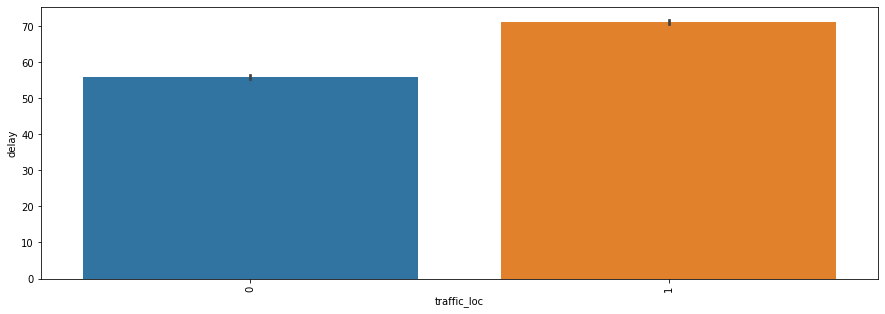

In [62]:
# df.loc[df['delay'] == 0, 'stop'].value_counts() > 0

traffic_loc = [125, 624, 131, 365, 3158, 358, 623, 359, 621, 88, 630, 3036, 1360, 77, 408,78,79,357,2741,571,561,83,1154,126,
               946,3032,2811,560,361,61,]

no_delays_stops = [2548, 3037, 2821, 321, 464,461,462,460,128,449,450,466]

df['traffic_loc'] = df['stop'].apply(lambda x: 1 if x in traffic_loc else 0)
df['no_delays_stops'] = df['stop'].apply(lambda x: 1 if x in no_delays_stops else 0)

plt.figure(figsize=(15, 5))
sns.barplot(x="traffic_loc", y="delay", data=df)
plt.xticks(rotation=90);

In [63]:
df["stop_name_cat"] = df["stop_name"].factorize()[0]
df["direction_cat"] = df["direction"].factorize()[0]

df['planned_time'] = pd.to_datetime(df['planned_time'], format='%Y-%m-%d %H:%M:%S')
df['day'] = df['planned_time'].dt.dayofweek
df['month'] = df['planned_time'].dt.month
df['hour'] = df['planned_time'].dt.hour
df['minute'] = df['planned_time'].dt.minute
df['rush_hours'] = df['hour'].apply(lambda x: 1 if (x > 5 and x < 10) | (x > 14 and x < 19) else 0)
df['night_hours'] = df['hour'].apply(lambda x: 1 if (x < 6 or x > 21) else 0)

df['vehicle_id_log'] = df['vehicle_id'].map(lambda x: np.log(x))
df['vehicle_id_cat'] = pd.factorize(df['vehicle_id_log'])[0]

#df['trip_id'] = df['trip_id'].apply(lambda x: int(str(x).split("63515585740")[1]))
df['trip_id_log'] = df['trip_id'].map(lambda x: np.log10(x))
df['trip_id_cat'] = df['trip_id'].factorize()[0]
df['stop_hour'] = df['stop']/df['hour']


In [64]:
print(df['seq_num'].isna().sum())

# Tutaj próbowałem imputować braki w seq_num, ale tylko pogarszało to sprawę

# df_kNN = df[['stop', 'direction_cat', 'number', 'trip_id_log', 'seq_num']]
# print('before:',df_kNN.isna().sum())

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))
# df_kNN = scaler.fit_transform(df_kNN)

# imputer = KNNImputer(n_neighbors=10)
# df_kNN = imputer.fit_transform(df_kNN)

# df_kNN = scaler.inverse_transform(df_kNN)

# df_kNN = pd.DataFrame(data = df_kNN, columns=['stop','direction_cat', 'number','trip_id_log', 'seq_num'])
# df_kNN['seq_num'] = df_kNN['seq_num'].map(lambda x: np.ceil(x))


# print('after:',df_kNN.isna().sum())

# df['seq_num'] = df_kNN['seq_num']


2382


In [65]:
df['high_seq_num'] = df['seq_num'].map(lambda x: x > 20)
df['seq_num'] = df['seq_num'].fillna(99)
df['trip_id_seq_num_number'] = df['trip_id_log']*df['seq_num']*df['number']
df['stop_seqnum'] = df['stop']/df['seq_num']

In [66]:
seq_num_dict = df.groupby('stop').agg(np.median)['seq_num'].to_dict()
df['seq_num_median'] = df['stop'].map(seq_num_dict)
seq_num_dict = df.groupby('stop').agg(pd.Series.mode)['seq_num'].to_dict()
df['seq_num_mode'] = df['stop'].map(seq_num_dict)
df['seq_num_power2'] = df['seq_num']*df['seq_num']

df['seq_num_median'].value_counts()

12.0    41178
14.0    29459
13.0    27237
15.0    25430
5.0     16367
10.0    16159
8.0     15718
16.0    15420
1.0     13063
3.0     12013
11.0    11839
18.0     9788
4.0      9757
17.0     9381
7.0      8564
6.0      8455
9.0      6088
20.0     5887
2.0      5554
23.0     5079
21.0     3656
19.0     3518
25.0     2622
22.0     1796
26.0     1224
33.0      855
31.0      847
32.0      693
29.0      355
35.0      149
99.0        1
Name: seq_num_median, dtype: int64

In [67]:
# Alternatives

freq_enc = df.groupby('hour').size()/len(df)
df['hour_frec_enc'] = df['hour'].map(freq_enc)

freq_enc = df.groupby('seq_num').size()/len(df)
df['seq_num_frec_enc'] = df['seq_num'].map(freq_enc)

freq_enc = df.groupby('day').size()/len(df)
df['day_frec'] = df['day'].map(freq_enc)

mean_encode = df.groupby('seq_num')['delay'].mean()
df['seq_num_m_enc'] = df.loc[:, 'seq_num_m_enc'] = df['seq_num'].map(mean_encode)

mean_encode = df.groupby('hour')['delay'].mean()
df['hour_m_enc'] = df['hour'].map(freq_enc)

mean_encode = df.groupby('number')['delay'].size()/len(df)
df['number_frec_enc'] = df['number'].map(mean_encode)

mean_encode = df.groupby('direction_cat')['delay'].size()/len(df)
df['direction_cat_fenc'] = df['direction_cat'].map(mean_encode)

In [68]:
df['time_diff'] = df['planned_time'].diff()
df['time_diff'] = df['time_diff'].dt.total_seconds()
df['stop_diff'] = df['stop'].diff()
#for x, y in zip(df['time_diff'], df['stop_diff']):
#    if y != 0:
#        x = 0
df['time_diff'] = df['time_diff'].fillna(0)
#df = df.sort_index()
df['time_diff'].value_counts()

 0.0         84271
 60.0        59102
-60.0        57264
 120.0       29546
-120.0       28559
 180.0       13618
-180.0       12921
 240.0        6114
-240.0        5795
 300.0        2719
-300.0        2611
 360.0        1308
-360.0        1214
-420.0         684
 420.0         658
 480.0         365
-480.0         360
-540.0         244
 540.0         236
-600.0         126
 600.0         125
 660.0          68
-660.0          60
 720.0          48
-720.0          39
-780.0          32
 780.0          28
 840.0          10
-840.0          10
 86520.0         2
 86400.0         1
 16680.0         1
 1140.0          1
-960.0           1
 187800.0        1
-691620.0        1
 86640.0         1
 86820.0         1
-1080.0          1
 15660.0         1
 15420.0         1
 15300.0         1
 14280.0         1
-900.0           1
 259080.0        1
Name: time_diff, dtype: int64

In [69]:
df_stopname_delay = df_train[["stop_name", "delay"]].groupby("stop_name").agg(
    mean_stopname_delay=("delay", "mean"),
    median_stopname_delay=("delay", "median"),
    count_stopname_delay=("delay", "count"),
    std_stopname_delay=("delay", "std"),
    count_zeros_stopname_delay=("delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_stopname_delay=("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

df_stopname_delay
df = pd.merge(df, df_stopname_delay, on="stop_name")

def df_group_delay(df_train, groupby_feats):
    agg_params = {
        "mean_{}_delay".format("_".join(groupby_feats)): ("delay", "mean"),
        "median_{}_delay".format("_".join(groupby_feats)): ("delay", "median"),
        "count_{}_delay".format("_".join(groupby_feats)): ("delay", "count"),
        "std_{}_delay".format("_".join(groupby_feats)): ("delay", "std"),
        "count_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: len([x for x in vals if x == 0]) ),
        "prob_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
    }
    
    return df_train[groupby_feats + ["delay"]].groupby(groupby_feats).agg(
        **agg_params
    ).reset_index()

df_tmp = df_group_delay(df_train, ["stop_name"])
if "mean_stopname_delay" not in df:
    df = pd.merge(df, df_tmp, on="stop_name", how="left")
    
df_tmp = df_group_delay(df_train, ["stop_name", "direction"])
if "mean_stopname_direction_delay" not in df:
    df = pd.merge(df, df_tmp, on=["stop_name", "direction"], how="left")


# Przygotowanie zmiennych do modelu

In [70]:
feats = df.select_dtypes("number").columns
black_list = ["id", "delay", "trip_id", 'trip_id_log', 'vehicle_id', 'super_seq', 'stop_name_cat', 'est_delay', 'minute', 'seq_num_^2_median', 
              'seq_num_tmp','no_delays_stops','seq_num_power2', 'trip_id_seq_num_number_m_frec','day_frec','trip_id_cat', 'stop_diff']
feats = [x for x in feats if x not in black_list]

feats

['stop',
 'number',
 'seq_num',
 'traffic_loc',
 'direction_cat',
 'day',
 'month',
 'hour',
 'rush_hours',
 'night_hours',
 'vehicle_id_log',
 'vehicle_id_cat',
 'stop_hour',
 'trip_id_seq_num_number',
 'stop_seqnum',
 'seq_num_median',
 'seq_num_mode',
 'hour_frec_enc',
 'seq_num_frec_enc',
 'seq_num_m_enc',
 'hour_m_enc',
 'number_frec_enc',
 'direction_cat_fenc',
 'time_diff',
 'mean_stopname_delay',
 'median_stopname_delay',
 'count_stopname_delay',
 'std_stopname_delay',
 'count_zeros_stopname_delay',
 'prob_zeros_stopname_delay',
 'mean_stop_name_direction_delay',
 'median_stop_name_direction_delay',
 'count_stop_name_direction_delay',
 'std_stop_name_direction_delay',
 'count_zeros_stop_name_direction_delay',
 'prob_zeros_stop_name_direction_delay']

In [71]:
# Rozdzielenie TRAIN i TEST
df_train = df[ df["delay"].notnull() ].copy().fillna(-1)
df_test = df[ df["delay"].isnull() ].copy().fillna(-1)


X_train = df_train[feats].values
y_train = df_train["delay"].values
X_test = df_test[feats].values

X_train.shape, y_train.shape, X_test.shape

((175986, 36), (175986,), (132166, 36))

# MODELE

In [89]:
def get_models(use_dummy=False):
    
    models = [('dummy', DummyRegressor(strategy='median'))] if use_dummy else []

    models += [
       ('xgboost', xgb.XGBRegressor(n_estimators=50, max_depth=5, eta=0.4, random_state=0,)),
       ('catboost', ctb.CatBoostRegressor(n_estimators=50, max_depth=5, learning_rate=0.4,  random_state=0, verbose=False)),
       ('lightgbm', lgb.LGBMRegressor(n_estimators=50, max_depth=5, learning_rate=0.2, random_state=0)),
    ]
    
    return models

        
def run_experiment(model_name, model, X, y, exp_name, cv=3, scoring=["neg_mean_absolute_error", "neg_mean_squared_error",  "neg_median_absolute_error", "r2"], tags={}, params={}, template_for_run_name="{}"):
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    
    model_str = str(model).split("(")[0]     

    with mlflow.start_run(experiment_id=_eid(exp_name), run_name=template_for_run_name.format(model_name)) as run:
        tags["model"] = model_str
        tags["X.shape"] = X.shape
        tags["y.shape"] = y.shape
        
        mlflow.set_tags(tags)
        result = cross_validate(model, X, y, scoring=scoring, return_train_score=True, return_estimator=True)
        estimator = result.get("estimator")
        if estimator:
            del result["estimator"]
        
        ### TRACK PARAMS
        params.update(model.get_params()) 
        params.update(tags)
        params.update({
            "cv": str(cv),
            # Poniższy kod wymaga jakiegoś fajnego rozwiązania <- mlflow ma ograniczenie do 250 znaków.
            "feats":feats[:5],
            "feats_2":feats[5:7],
            "feats_3":feats[7:10],
            "feats_4":feats[10:11],
            "feats_5":feats[11],
            'feats_6':feats[12],
            "feats_7":feats[13],
            "feats_7":feats[14],
            "feats_8":feats[15],
            "feats_9":feats[16],
            "feats_10":feats[17],
            "feats_11":feats[18],
            "feats_12":feats[19],
            "feats_13":feats[20],
            "feats_14":feats[21],
            "feats_15":feats[22],
            "feats_16":feats[23],
            "feats_17":feats[24],
            "feats_18":feats[25],
            "feats_16":feats[26],
            "feats_17":feats[27],
            "feats_18":feats[28],
            "feats_19":feats[29:],
            
        })
        mlflow.log_params(params)

        ### TRACK METRICS
        metrics = {}
        metrics.update({"avg_{}".format(x): np.mean(result[x]) for x in result})
        metrics.update({"std_{}".format(x): np.std(result[x]) for x in result})

        mlflow.log_metrics(metrics)

        print("model={}, {}\n".format(model_name, metrics))

In [90]:
for model_name, model in get_models():
    tags = {}
    params = {}
    run_experiment(model_name, model, X_train, y_train, exp_name="starter1", tags=tags, params=params)

model=xgboost, {'avg_fit_time': 9.208625888824463, 'avg_score_time': 0.07795076370239258, 'avg_test_neg_mean_absolute_error': -30.415995842460642, 'avg_train_neg_mean_absolute_error': -29.401115327124575, 'avg_test_neg_mean_squared_error': -1824.7595815241743, 'avg_train_neg_mean_squared_error': -1700.7944441251507, 'avg_test_neg_median_absolute_error': -22.28459014892578, 'avg_train_neg_median_absolute_error': -21.51019744873047, 'avg_test_r2': 0.731302833946529, 'avg_train_r2': 0.7500035991515398, 'std_fit_time': 8.231686184334844, 'std_score_time': 0.022142177952685287, 'std_test_neg_mean_absolute_error': 1.2333271988602612, 'std_train_neg_mean_absolute_error': 0.32929224037892413, 'std_test_neg_mean_squared_error': 103.09150843753049, 'std_train_neg_mean_squared_error': 25.321480481590434, 'std_test_neg_median_absolute_error': 1.2903543271073004, 'std_train_neg_median_absolute_error': 0.39459994158319983, 'std_test_r2': 0.010572568857917844, 'std_train_r2': 0.003038724949387923}

m

# xgbfir

In [28]:
model = xgb.XGBRegressor(n_estimators=50, max_depth=5, eta=0.4, random_state=0)
model.fit(X_train, y_train)
xgbfir.saveXgbFI(model, feature_names=feats, OutputXlsxFile='tram_fi.xlsx')

# mlflow

In [625]:
!mlflow ui 

[2021-10-29 10:46:41 +0000] [150] [INFO] Starting gunicorn 20.1.0
[2021-10-29 10:46:41 +0000] [150] [INFO] Listening at: http://127.0.0.1:5000 (150)
[2021-10-29 10:46:41 +0000] [150] [INFO] Using worker: sync
[2021-10-29 10:46:41 +0000] [152] [INFO] Booting worker with pid: 152
^C
[2021-10-29 10:46:48 +0000] [150] [INFO] Handling signal: int
[2021-10-29 10:46:49 +0000] [152] [INFO] Worker exiting (pid: 152)


https://pml.dataworkshop.eu/hub/user-redirect/proxy/5000/

# Do Kaggle

In [91]:
model = xgb.XGBRegressor(n_estimators=50, max_depth=5, eta=0.4, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred[ y_pred < 0 ] = 0
df_test["delay"] = y_pred

In [92]:
df_test[ ["id", "delay"] ].to_csv('../output/thirteenth.csv', index=False) 